In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf #we'll use tensorflow as our low-level deep learning framework
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential #we'll be building a feed-forward neural network with some branching in the output layer
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation #we'll use several different types of layers in our neural network
from keras.optimizers import Adam # Import Adam optimizer
from tensorflow import keras #we'll use keras as a wrapper for tensorflow
from tensorflow.keras.utils import plot_model, to_categorical #used to visualize our neural network structures
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#set the tensorflow random seed to ensure reproducible results
tf.keras.utils.set_random_seed(42)

In [ ]:
#load the project data into a pandas dataframe
df = pd.read_pickle('Project 02 - Data.pkl.gz')

In [ ]:
#create a dataframe containing only those rows for which
#emotion predictions need to be made
df_predict = df[df.emotion == 'unknown'].copy()
display(df_predict)

#remove all unknown rows from the original 'df' dataframe
df_main = df[df.emotion != 'unknown'].copy()
display(df_main)

,image_id,emotion,pixels
3,3,unknown,"[[[135], [148], [149], [159], [166], [170], [1..."
11,11,unknown,"[[[39], [36], [56], [47], [27], [38], [34], [2..."
41,41,unknown,"[[[52], [54], [84], [124], [149], [161], [169]..."
65,65,unknown,"[[[255], [255], [255], [255], [254], [255], [2..."
72,72,unknown,"[[[254], [254], [254], [254], [254], [254], [2..."
...,...,...,...
12906,12906,unknown,"[[[63], [174], [171], [147], [137], [146], [15..."
12951,12951,unknown,"[[[140], [140], [144], [150], [155], [155], [1..."
12958,12958,unknown,"[[[32], [30], [27], [25], [24], [24], [33], [4..."
12980,12980,unknown,"[[[113], [115], [118], [121], [123], [128], [1..."


,image_id,emotion,pixels
0,0,anger,"[[[16], [12], [11], [22], [25], [25], [29], [2..."
1,1,sadness,"[[[135], [136], [137], [134], [133], [138], [1..."
2,2,neutral,"[[[107], [111], [111], [113], [111], [124], [1..."
4,4,neutral,"[[[131], [119], [135], [129], [126], [147], [1..."
5,5,neutral,"[[[137], [133], [139], [135], [133], [135], [1..."
...,...,...,...
12995,12995,surprise,"[[[18], [26], [40], [58], [85], [111], [130], ..."
12996,12996,anger,"[[[252], [251], [251], [250], [253], [243], [2..."
12997,12997,happiness,"[[[66], [80], [92], [108], [132], [148], [159]..."
12998,12998,surprise,"[[[17], [22], [24], [19], [28], [54], [50], [5..."


In [ ]:
#split data into training and testing sets
df_train, df_test = train_test_split(df_main, test_size=0.3, shuffle=True, random_state=42)

display(df_train.shape)
display(df_test.shape)

(8400, 3)

(3600, 3)

In [ ]:
# Create the feature vector
train_features = df_train.drop(columns=['image_id','emotion'])
test_features = df_test.drop(columns=['image_id','emotion'])
predict_features = df_predict.drop(columns=['image_id','emotion'])

In [ ]:
#get the training and testing labels
train_labels = df_train.emotion#.to_list()
test_labels = df_test.emotion#.to_list()

In [ ]:
# Get unique labels from the main dataframe
unique_labels = df_main['emotion'].unique()
print("Unique emotion labels:", unique_labels)

Unique emotion labels: ['anger' 'sadness' 'neutral' 'surprise' 'happiness']


In [ ]:
#define the number of filters, filter size, and max pooling window size to use in the convolution process
number_of_filters = 32
filter_size = 3 #3 pixels x 3 pixels
max_pooling_window_size = 2 #2 pixels x 2 pixels

#define the structure of the CNN model
input_shape=(48, 48, 1) #the shape of the input arrays (28 pixels x 28 pixels x 1 channel)
cnn = Sequential() #this will be a sequential model (as opposed, for example, to a recurrent model)

# First Convolutional Block
cnn.add(Conv2D(number_of_filters, filter_size, input_shape=input_shape))
cnn.add(BatchNormalization()) # Add Batch Normalization
cnn.add(Activation('relu')) # Add Activation after Batch Normalization
cnn.add(MaxPooling2D(pool_size=max_pooling_window_size))

# Second Convolutional Block
cnn.add(Conv2D(number_of_filters * 2, filter_size))
cnn.add(BatchNormalization()) # Add Batch Normalization
cnn.add(Activation('relu')) # Add Activation after Batch Normalization
cnn.add(MaxPooling2D(pool_size=max_pooling_window_size))

# Flattening and Dense Layers
cnn.add(Flatten()) #add the flattening layer to the network
cnn.add(Dense(128)) #add a hidden layer with more nodes
cnn.add(BatchNormalization()) # Add Batch Normalization
cnn.add(Activation('relu')) # Add Activation after Batch Normalization
cnn.add(Dropout(0.5)) # Increased dropout rate to 0.5

# Output Layer
cnn.add(Dense(len(unique_labels), activation='softmax')) #add the output layer

#compile the CNN model. We'll use the Adam optimization algorithm, a categorical cross entropy loss function
#(since we're predicting multiple category labels), and accuracy as the primary performance metric
# Changed optimizer to 'rmsprop' with a custom learning rate
optimizer = Adam(learning_rate=0.0005) # Use Adam class
cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Encode string labels to integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print("Labels encoded to integers.")

Labels encoded to integers.


In [ ]:
# Convert encoded labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=len(unique_labels))
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=len(unique_labels))

# Convert features to NumPy arrays and reshape for CNN input
train_features_array = np.stack(train_features['pixels'].values).reshape(-1, 48, 48, 1)
test_features_array = np.stack(test_features['pixels'].values).reshape(-1, 48, 48, 1)

print("Labels and features prepared for training.")

Labels and features prepared for training.


In [ ]:
# Create the LearningRateScheduler callback
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf # Ensure tensorflow is imported

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        # Ensure the result is a float
        return float(lr * tf.math.exp(-0.01).numpy())

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with the callback
history = cnn.fit(datagen.flow(train_features_array, train_labels_one_hot, batch_size=32),
                  epochs=200,
                  validation_data=(test_features_array, test_labels_one_hot),
                  steps_per_epoch=len(train_features_array) // 32,
                  callbacks=[lr_scheduler] # Add the callback here
                 )

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.2838 - loss: 1.8808 - val_accuracy: 0.4031 - val_loss: 1.4433 - learning_rate: 5.0000e-04
Epoch 2/200
  1/262 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.2812 - loss: 1.8255

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.2812 - loss: 1.8255 - val_accuracy: 0.4044 - val_loss: 1.4449 - learning_rate: 5.0000e-04
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 75s 142ms/step - accuracy: 0.3422 - loss: 1.5923 - val_accuracy: 0.4208 - val_loss: 1.3796 - learning_rate: 5.0000e-04
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3438 - loss: 1.6693 - val_accuracy: 0.4258 - val_loss: 1.3619 - learning_rate: 5.0000e-04
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.4018 - loss: 1.4332 - val_accuracy: 0.4375 - val_loss: 1.3663 - learning_rate: 5.0000e-04
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5938 - loss: 1.0502 - val_accuracy: 0.4439 - val_loss: 1.3578 - learning_rate: 5.0000e-04
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.4340 - loss: 1.3718 - val_accuracy: 0.4572 - val_loss: 1.3098 - learning_rate: 5.0000e-04
Epoch 8/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - ac

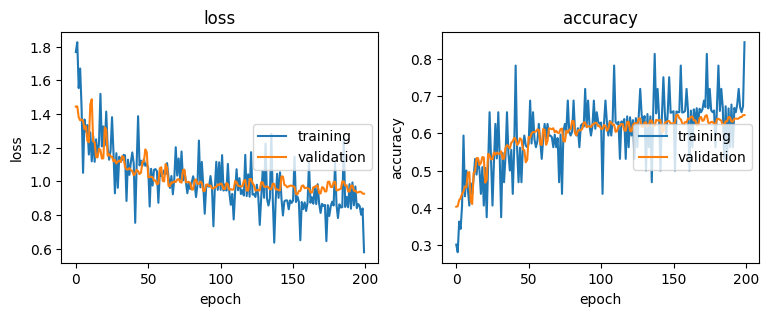

In [ ]:
#plot the training loss and accuracy
f, axis_array = plt.subplots(1, 2, figsize=(9, 3)) #display both images in 1 row
data_to_show = ['loss', 'accuracy']
for i in range(2):
  axis_array[i].plot(history.history[data_to_show[i]])
  axis_array[i].plot(history.history['val_' + data_to_show[i]])
  axis_array[i].title.set_text(data_to_show[i])
  axis_array[i].set_ylabel(data_to_show[i])
  axis_array[i].set_xlabel('epoch')
  axis_array[i].legend(['training', 'validation'], loc='center right')

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn.evaluate(test_features_array, test_labels_one_hot, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9425
Test Accuracy: 0.6439
